# Chapter 6: Multiple Linear Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [2]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline


In [4]:
#pip install statsmodels

You should consider upgrading via the 'c:\Users\hechu\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Table 6.3

In [3]:
# Reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = dmba.load_data('ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

predictors = ['Age_08_04', 
              'KM', 'Fuel_Type', 'HP', 'Automatic', 'Doors', 
              'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 'Airco', 'Automatic_airco', 'CD_Player', 'Powered_Windows', 
              'Sport_Model', 'Tow_Bar']
outcome = 'Price'

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, train_size=0.5, random_state=1)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))

intercept  10507.531598087164
           Predictor  coefficient
0          Age_08_04  -113.694378
1                 KM    -0.019815
2                 HP    32.636613
3          Automatic   689.861569
4              Doors   171.014809
5      Quarterly_Tax    17.326548
6      Mfr_Guarantee   124.590446
7   Guarantee_Period    81.154819
8              Airco   155.731656
9    Automatic_airco  3025.204329
10         CD_Player   399.634465
11   Powered_Windows   499.226837
12       Sport_Model   604.651494
13           Tow_Bar  -125.630928
14  Fuel_Type_Diesel   953.660217
15  Fuel_Type_Petrol  1254.423913

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1244.5216
            Mean Absolute Error (MAE) : 945.9544
          Mean Percentage Error (MPE) : -0.8986
Mean Absolute Percentage Error (MAPE) : 8.2421


In [14]:
pred_y = car_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

adjusted r2 :  0.8882954065407929
AIC :  8581.44504236433
BIC :  8657.30798813593


## Table 6.4

In [15]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

        Predicted  Actual     Residual
507  10282.576489   11500  1217.423511
818  10428.647518    8950 -1478.647518
452  11037.968281   11450   412.031719
368  13742.698836   11450 -2292.698836
242  11915.384527   11950    34.615473
929   9804.992294    9995   190.007706
262  13065.595182   13500   434.404818
810   9237.326625    7950 -1287.326625
318  11496.031566    9900 -1596.031566
49   20456.660876   21950  1493.339124
446  11368.817783   11950   581.182217
142  20829.701664   19950  -879.701664
968  11054.525911    9950 -1104.525911
345  13874.867091   14950  1075.132909
971   8814.177442   10495  1680.822558
133  17307.551722   15950 -1357.551722
104  18374.582830   19450  1075.417170
6    15108.727407   16900  1791.272593
600  12852.378895   11250 -1602.378895
496  11278.987644   11750   471.012356

Regression statistics

                      Mean Error (ME) : -44.2898
       Root Mean Squared Error (RMSE) : 1241.0357
            Mean Absolute Error (MAE) : 946.7135
         

## Figure 6.1
Determine the residuals and create a histogram

0.77


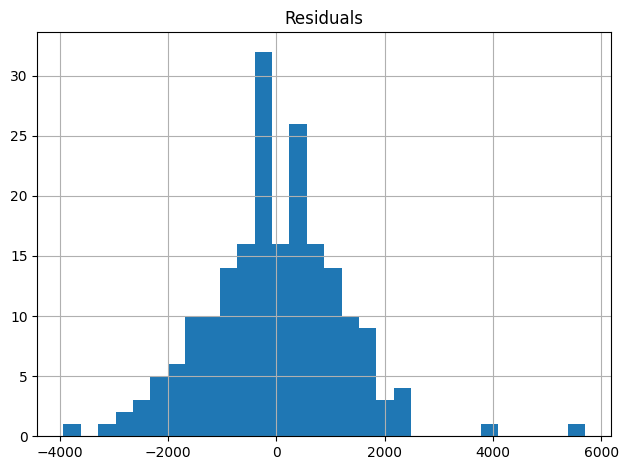

In [27]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=30)

plt.tight_layout()
plt.show()

## Table 6.5
Run an exhaustive search. The Fuel type column is categorical and needs to be converted into dummy variables.

In [17]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj          AIC  Age_08_04  Airco  Automatic  Automatic_airco  CD_Player  Doors   
0    1  0.753146  8963.206470       True  False      False            False      False  False  \
1    2  0.827048  8786.310045       True  False      False             True      False  False   
2    3  0.844565  8733.909259       True  False      False             True      False  False   
3    4  0.854127  8703.154540       True  False      False             True      False  False   
4    5  0.871198  8641.913198       True  False      False             True      False  False   
5    6  0.877018  8619.781820       True  False      False             True      False  False   
6    7  0.880200  8607.657855       True  False      False             True      False  False   
7    8  0.882526  8598.837660       True  False      False             True      False  False   
8    9  0.884670  8590.607650       True  False      False             True      False   True   
9   10  0.886286  8584.533125 

## Table 6.6 backward elimination

In [18]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, Tow_Bar, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=8581.45
Step: score=8580.33, remove Tow_Bar
Step: score=8579.33, remove Airco
Step: score=8578.34, remove Mfr_Guarantee
Step: score=8578.34, remove None
['Age_08_04', 'KM', 'HP', 'Automatic', 'Doors', 'Quarterly_Tax', 'Guarantee_Period', 'Automatic_airco', 'CD_Player', 'Powered_Windows', 'Sport_Model', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol']


In [19]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : -36.3664
       Root Mean Squared Error (RMSE) : 1261.4573
            Mean Absolute Error (MAE) : 963.4325
          Mean Percentage Error (MPE) : -1.8819
Mean Absolute Percentage Error (MAPE) : 8.7714


## Table 6.7 Forward selection

In [20]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, Tow_Bar, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=9661.69, constant
Step: score=8963.21, add Age_08_04
Step: score=8786.31, add Automatic_airco
Step: score=8733.91, add HP
Step: score=8705.68, add KM
Step: score=8641.91, add Quarterly_Tax
Step: score=8619.78, add Powered_Windows
Step: score=8607.66, add Sport_Model
Step: score=8598.84, add Guarantee_Period
Step: score=8590.61, add Doors
Step: score=8584.53, add Automatic
Step: score=8579.79, add CD_Player
Step: score=8579.61, add Fuel_Type_Petrol
Step: score=8578.34, add Fuel_Type_Diesel
Step: score=8578.34, add None
['Age_08_04', 'Automatic_airco', 'HP', 'KM', 'Quarterly_Tax', 'Powered_Windows', 'Sport_Model', 'Guarantee_Period', 'Doors', 'Automatic', 'CD_Player', 'Fuel_Type_Petrol', 'Fuel_Type_Diesel']


In [22]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, Tow_Bar, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=9661.69, constant
Step: score=8963.21, add Age_08_04
Step: score=8786.31, add Automatic_airco
Step: score=8733.91, add HP
Step: score=8705.68, add KM
Step: score=8641.91, add Quarterly_Tax
Step: score=8619.78, add Powered_Windows
Step: score=8607.66, add Sport_Model
Step: score=8598.84, add Guarantee_Period
Step: score=8590.61, add Doors
Step: score=8584.53, add Automatic
Step: score=8579.79, add CD_Player
Step: score=8579.61, add Fuel_Type_Petrol
Step: score=8578.34, add Fuel_Type_Diesel
Step: score=8578.34, unchanged None
['Age_08_04', 'Automatic_airco', 'HP', 'KM', 'Quarterly_Tax', 'Powered_Windows', 'Sport_Model', 'Guarantee_Period', 'Doors', 'Automatic', 'CD_Player', 'Fuel_Type_Petrol', 'Fuel_Type_Diesel']


## Table XX regularized methods

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lasso = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Lasso(alpha=1)],
])
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))

lasso_cv = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LassoCV(cv=5)],
])
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv['model'].alpha_)
print(lasso_cv['model'].coef_)

ridge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Ridge(alpha=1)],
])
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))

bayesianRidge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', BayesianRidge()],
])
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', 
      bayesianRidge['model'].lambda_ / bayesianRidge['model'].alpha_)


Regression statistics

                      Mean Error (ME) : -43.7331
       Root Mean Squared Error (RMSE) : 1241.8072
            Mean Absolute Error (MAE) : 946.7051
          Mean Percentage Error (MPE) : -1.9044
Mean Absolute Percentage Error (MAPE) : 8.6048

Regression statistics

                      Mean Error (ME) : -42.4695
       Root Mean Squared Error (RMSE) : 1243.6887
            Mean Absolute Error (MAE) : 946.6830
          Mean Percentage Error (MPE) : -1.9034
Mean Absolute Percentage Error (MAPE) : 8.6021
Lasso-CV chosen regularization:  3.2856840628927344
[-1965.70726247  -717.08280396   480.66282082   147.81342565
   163.49298932   744.09537408    58.96939077   240.10749592
    74.99799982   840.30765789   178.37045242   239.58777015
   267.13437861   -51.97178995   259.2338857    369.45559603]

Regression statistics

                      Mean Error (ME) : -44.4681
       Root Mean Squared Error (RMSE) : 1241.5647
            Mean Absolute Error (MAE) : 946.71

In [24]:
linearRegression = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LinearRegression()],
])
linearRegression.fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -44.2898
       Root Mean Squared Error (RMSE) : 1241.0357
            Mean Absolute Error (MAE) : 946.7135
          Mean Percentage Error (MPE) : -1.9049
Mean Absolute Percentage Error (MAPE) : 8.6060


In [25]:
pd.DataFrame({
    'features': train_X.columns, 
    'linear regression': linearRegression['model'].coef_, 
    'lassoCV': lasso_cv['model'].coef_, 
    'bayesianRidge': bayesianRidge['model'].coef_,
})

,features,linear regression,lassoCV,bayesianRidge
0,Age_08_04,-1960.706932,-1965.707262,-1931.803835
1,KM,-714.888876,-717.082804,-728.850120
2,HP,487.242387,480.662821,484.245473
3,Automatic,150.351843,147.813426,148.514998
4,Doors,164.135378,163.492989,167.954614
5,Quarterly_Tax,760.588523,744.095374,736.261945
6,Mfr_Guarantee,62.053547,58.969391,64.181169
7,Guarantee_Period,247.238606,240.107496,245.857940
8,Airco,75.741320,74.998000,81.525950
9,Automatic_airco,839.154819,840.307658,839.632529


## Table 6.10

In [26]:
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     249.0
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          2.36e-221
Time:                        21:00:21   Log-Likelihood:                -4272.7
No. Observations:                 500   AIC:                             8579.
Df Residuals:                     483   BIC:                             8651.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               